In [1]:
%matplotlib inline

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import sklearn.metrics
from sklearn.metrics import roc_auc_score


import warnings
warnings.filterwarnings('ignore')

### Загрузим тренировочные и тестовые данные

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_train.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender,Default
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,5,36.0,Male,0
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,5,29.0,Female,1
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaN,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,5,56.0,Female,0
3,46893387,2016-04-30,2016-03-22,NaN,NaN,NaN,NaN,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,5,27.0,Female,0
4,67128275,2016-09-19,2016-07-21,NaN,NaN,NaN,NaN,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,5,37.0,Female,0


### EDA

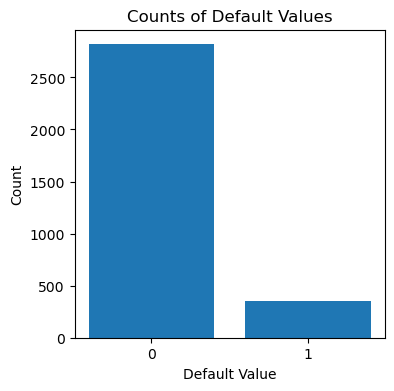

In [2]:
# Посмотрим на распределение таргета
count = df_train['Default'].value_counts()
plt.figure(figsize=(4,4))
plt.bar(count.index, count.values)
plt.xticks([0, 1])

plt.title('Counts of Default Values')
plt.xlabel('Default Value')
plt.ylabel('Count')

plt.show()

In [3]:
# Проверим все ли типы данны у нас в правильном формате. 
# Видим что некоторые данные связанные со временем надо будет перевести в datetime формат
df_train.dtypes

Deal_id                     int64
Deal_date                  object
First_deal_date            object
Secret_dwarf_info_1       float64
Secret_dwarf_info_2       float64
Secret_dwarf_info_3       float64
First_default_date         object
Successful_deals_count    float64
Region                     object
Tavern                      int64
Hashed_deal_detail_1      float64
Hashed_deal_detail_2        int64
Hashed_deal_detail_3        int64
Hashed_deal_detail_4      float64
Hashed_deal_detail_5        int64
Hashed_deal_detail_6        int64
Age                       float64
Gender                     object
Default                     int64
dtype: object

In [4]:
# Посмотрим на данные в целом, есть ли пропуски и вылеты
df_train.describe(include=[float,int])

,Deal_id,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Default
count,3.168000e+03,535.000000,535.000000,535.000000,3154.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.0,3168.000000,3168.000000
mean,4.605727e+07,3.935514,-2.299065,5.267290,1.043754,13.350694,2.518939,-2.404356,8.462437,3.193813,-2.981692,5.0,36.411616,0.110795
std,5.370953e+07,0.888467,0.734579,0.498645,1.649416,8.851891,0.351308,2.474564,3.521127,2.048743,0.245540,0.0,10.821444,0.313928
min,5.856790e+05,2.500000,-3.000000,5.000000,0.000000,2.000000,2.500000,-3.000000,5.000000,2.500000,-3.000000,5.0,20.000000,0.000000
25%,2.761608e+07,3.500000,-3.000000,5.000000,0.000000,7.000000,2.500000,-3.000000,6.000000,2.500000,-3.000000,5.0,28.000000,0.000000
50%,4.349426e+07,3.500000,-2.000000,5.000000,0.000000,8.000000,2.500000,-3.000000,8.000000,2.500000,-3.000000,5.0,34.000000,0.000000
75%,5.778544e+07,4.500000,-2.000000,5.000000,2.000000,15.000000,2.500000,-3.000000,10.000000,2.500000,-3.000000,5.0,43.000000,0.000000
max,6.927701e+08,9.500000,2.000000,8.000000,17.000000,58.000000,17.500000,78.000000,29.000000,37.500000,4.000000,5.0,72.000000,1.000000


In [5]:
# проверим df на пропуски
df_train.isnull().sum()

Deal_id                      0
Deal_date                    0
First_deal_date              0
Secret_dwarf_info_1       2633
Secret_dwarf_info_2       2633
Secret_dwarf_info_3       2633
First_default_date        2633
Successful_deals_count      14
Region                       7
Tavern                       0
Hashed_deal_detail_1         0
Hashed_deal_detail_2         0
Hashed_deal_detail_3         0
Hashed_deal_detail_4         0
Hashed_deal_detail_5         0
Hashed_deal_detail_6         0
Age                          0
Gender                       0
Default                      0
dtype: int64

In [6]:
# Гипотеза не сработала:
# Так как фитчи Secret_dwarf_info_1 Secret_dwarf_info_2 Secret_dwarf_info_3 
# имеют большое количество пропусков,порядка 83%, то целесообразние будет их удалить в дальнейшем из диатасета
# round(df.describe(include=[float,int])['Secret_dwarf_info_1']['count']/ df.describe(include=[float,int])['Deal_id']['count'],2)

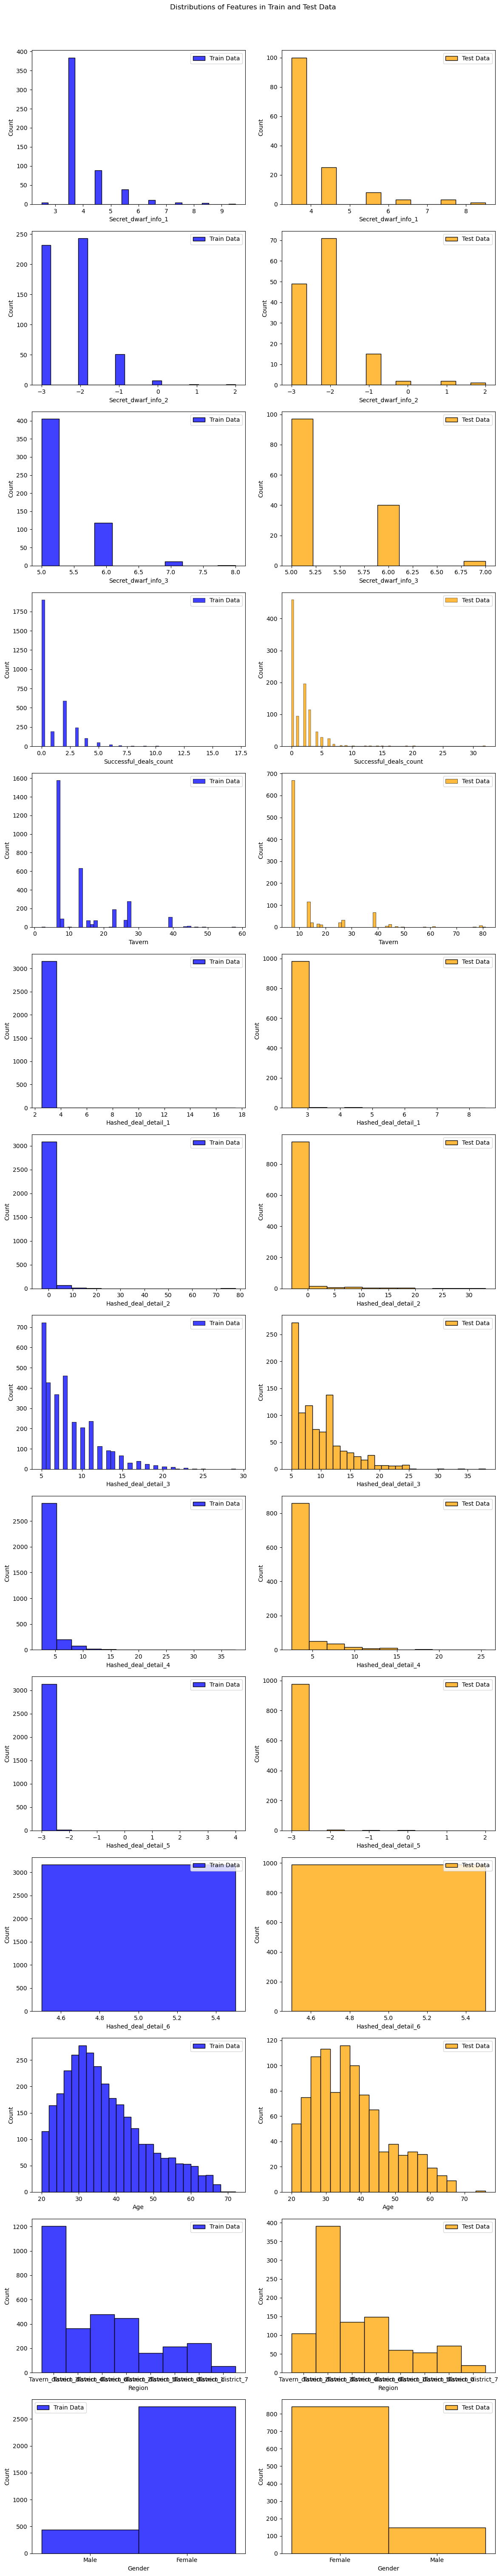

In [7]:
# Выберем признаки, для которых хотим построить распределения
selected_features = ['Secret_dwarf_info_1', 'Secret_dwarf_info_2','Secret_dwarf_info_3', 'Successful_deals_count', 'Tavern',
       'Hashed_deal_detail_1', 'Hashed_deal_detail_2', 'Hashed_deal_detail_3','Hashed_deal_detail_4', 'Hashed_deal_detail_5',
                    'Hashed_deal_detail_6', 'Age', 'Region','Gender']

# Создадим сетку графиков
fig, axes = plt.subplots(nrows=len(selected_features), ncols=2, figsize=(12, 60))

# Построим распределения для каждого признака
for i, feature in enumerate(selected_features):
    # Распределение для тренировочных данных
    sns.histplot(df_train[feature], ax=axes[i, 0], color='blue', label='Train Data')
    # Распределение для тестовых данных
    sns.histplot(df_test[feature], ax=axes[i, 1], color='orange', label='Test Data')

    # Добавим метки и заголовки
    axes[i, 0].set_xlabel(feature)
    axes[i, 1].set_xlabel(feature)
    axes[i, 0].legend()
    axes[i, 1].legend()

# Добавим общий заголовок
plt.suptitle('Distributions of Features in Train and Test Data', y=1.01)  # Размещаем заголовок над всеми графиками
plt.tight_layout()
plt.show()

### Выводы:

1. **Явных выбросов мы не наблюдаем**, зато видно большое количество пропусков в фичах:
   - *Secret_dwarf_info_1*
   - *Secret_dwarf_info_2*
   - *Secret_dwarf_info_3*
   - *First_default_date*
   <br>Можно предположить что эти фитчи связаны с First_default_date поэтому, вероятнее всего, их надо будет удалить из датасета, оствив только First_default_date как категориальный признак.  **Итог:гипотеза не верна** 
   <br>
      
   <br>
        
2. *Присутствует сильный дисбаланс классов.*

3. Есть немного пропусков в *Successful_deals_count* и *Region*. Заменим в будующем на 0 и моду соответственно

4. Признак *Hashed_deal_detail_6*	выглядит бесполезным в виду постоянности значений

In [8]:
# Найдем минимальную дату первого дефолта, для того чтобы потом применить ее для создания фитчей
min_date_str = (df_train.First_default_date.dropna().min())
min_date = datetime.datetime.strptime(min_date_str,'%Y-%m-%d')
min_date

datetime.datetime(2015, 5, 1, 0, 0)

### Подготовка данных

In [9]:
### Напишем функцию, заполняющую пропуски в данных

def fill_missing_data(data, min_date):
    
### Удалим столбец 'Hashed_deal_detail_6', который не несет информации для модели
    data.drop(['Hashed_deal_detail_6'], axis=1, inplace=True)
    
### Захэшированную информацию - средним
    for feature in [1, 2, 3]:
        col_name = f"Secret_dwarf_info_{feature}"
        mean_ = data[col_name].mean()
        data[col_name] = data[col_name].fillna(mean_)
        
### Регион - самым популярным  
    mode_region_value = data.Region.mode()[0]
    data['Region'] = data['Region'].fillna(mode_region_value)
    
### Первую дату дефолта можно заполнить, например, каким-то "выбросом" (чтобы в признаковом пространстве подальше отделить
### объекты с пропуском в этой колонке).Для этого выше мы искали min_date чтобы знать от чего вести отсчет
    
    date_for_missing_values = min_date - datetime.timedelta(days=365)
    
    date_ = str(date_for_missing_values)[:10]
    
    data['First_default_date'] = (
        data['First_default_date']
        .fillna(date_)
    )
    
### Количество успешных сделок - нулем
    data['Successful_deals_count'] = (
        data['Successful_deals_count']
        .fillna(0)
    )

    return data

In [10]:
### Применим функцию на тренировочных и тестовых данных

fill_missing_data(df_train, min_date)
fill_missing_data(df_test, min_date)

### Убедимся, что пропусков в данных нет:

df_train.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0)

In [11]:
### Напишем функцию, генерирующую новые признаки 
### на основании базовых

def create_new_features(data):
    
    ### Распарсим даты в год-месяц-день   
    data["First_deal_date"] = pd.to_datetime(data["First_deal_date"])
    data['First_deal_year']= data['First_deal_date'].apply(lambda x: x.year)
    data['First_deal_month'] = data['First_deal_date'].apply(lambda x: x.month)
    data['First_deal_day'] = data['First_deal_date'].apply(lambda x: x.day)

    data["Deal_date"] = pd.to_datetime(data["Deal_date"])
    data['Deal_year']= data['Deal_date'].apply(lambda x: x.year)
    data['Deal_month'] = data['Deal_date'].apply(lambda x: x.month)
    data['Deal_day'] = data['Deal_date'].apply(lambda x: x.day)

    data["First_default_date"] = pd.to_datetime(data["First_default_date"])
    data['First_default_year']= data['First_default_date'].apply(lambda x: x.year)
    data['First_default_month'] = data['First_default_date'].apply(lambda x: x.month)
    data['First_default_day'] = data['First_default_date'].apply(lambda x: x.day)
    
    ### Создадим фичу
    ### "время от первой сделки до первой просрочки" в днях
    
    data['Difference'] = (data['First_default_date'] - data['First_deal_date']).dt.days
    
    ### Отсортируем данные по Deal_date это нам в последующем пригодится для валидации через TimeSeriesSplit
    data.sort_values(by='Deal_date', inplace = True)
    
    ### Удалим старые колонки с датами
    data.drop(
        [
            'First_deal_date',
            'Deal_date',
            'First_default_date'
        ],
        axis=1,
        inplace=True
    )
    
    return data

In [12]:
### Применим функцию, убедимся в том, что все трансформировалось ровно так, как и планировали

create_new_features(df_train)
create_new_features(df_test)

df_train.head()

,Deal_id,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Default,First_deal_year,First_deal_month,First_deal_day,Deal_year,Deal_month,Deal_day,First_default_year,First_default_month,First_default_day,Difference
1084,585679,3.935514,-2.299065,5.26729,0.0,Tavern_district_3,23,2.5,-3,5,2.5,-3,22.0,Male,0,2015,2,19,2015,2,24,2014,5,1,-294
1047,5954693,3.935514,-2.299065,5.26729,0.0,Tavern_district_4,7,2.5,-3,5,2.5,-3,30.0,Female,0,2015,2,14,2015,2,28,2014,5,1,-289
1396,6829250,3.935514,-2.299065,5.26729,2.0,Tavern_district_1,23,2.5,-2,5,2.5,-3,34.0,Female,0,2015,3,5,2015,3,10,2014,5,1,-308
717,6878449,3.935514,-2.299065,5.26729,2.0,Tavern_district_6,7,2.5,-3,5,2.5,-3,23.0,Female,1,2015,2,27,2015,3,11,2014,5,1,-302
2877,7185789,3.935514,-2.299065,5.26729,0.0,Tavern_district_3,23,2.5,-2,5,2.5,-3,32.0,Female,0,2015,2,17,2015,3,17,2014,5,1,-292


In [13]:
### Напишем функцию, трансформирующую object колонки в числовой формат трансформировать прочие числовые (но категориальные)
### фичи не будем, так как планируем строить композиции деревьев в качестве моделей

# Применим MTE для пола и OHE для региона
# Посчитаем средние по тренировочному датасету т.к. на тесте средние таргетов взять невозможно

mean_gender = df_train.groupby('Gender')['Default'].mean()

def transform_object_cols(data, means=mean_gender):
    
    data['Gender'] = data['Gender'].map(mean_gender)
    
    dummy = pd.get_dummies(data.Region, drop_first=True)    
    data.drop('Region', axis=1, inplace=True)
    
    data[dummy.columns] = dummy
    
    return data

In [14]:
### Применим функцию, убедимся в том, что
### Все трансформировалось ровно так, 
### как мы и планировали

transform_object_cols(df_train)
transform_object_cols(df_test)

df_train.head()

,Deal_id,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Default,First_deal_year,First_deal_month,First_deal_day,Deal_year,Deal_month,Deal_day,First_default_year,First_default_month,First_default_day,Difference,Tavern_district_1,Tavern_district_2,Tavern_district_3,Tavern_district_4,Tavern_district_5,Tavern_district_6,Tavern_district_7
1084,585679,3.935514,-2.299065,5.26729,0.0,23,2.5,-3,5,2.5,-3,22.0,0.168565,0,2015,2,19,2015,2,24,2014,5,1,-294,False,False,True,False,False,False,False
1047,5954693,3.935514,-2.299065,5.26729,0.0,7,2.5,-3,5,2.5,-3,30.0,0.101502,0,2015,2,14,2015,2,28,2014,5,1,-289,False,False,False,True,False,False,False
1396,6829250,3.935514,-2.299065,5.26729,2.0,23,2.5,-2,5,2.5,-3,34.0,0.101502,0,2015,3,5,2015,3,10,2014,5,1,-308,True,False,False,False,False,False,False
717,6878449,3.935514,-2.299065,5.26729,2.0,7,2.5,-3,5,2.5,-3,23.0,0.101502,1,2015,2,27,2015,3,11,2014,5,1,-302,False,False,False,False,False,True,False
2877,7185789,3.935514,-2.299065,5.26729,0.0,23,2.5,-2,5,2.5,-3,32.0,0.101502,0,2015,2,17,2015,3,17,2014,5,1,-292,False,False,True,False,False,False,False


### Обучение модель

In [15]:
### Разделим таргеты и фичи

X_train = df_train.drop(['Default', 'Deal_id'], axis=1)
X_test = df_test.drop(['Deal_id'], axis=1)

Y_train = df_train['Default']

In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    random_state=111
)

model.fit(X_train, Y_train)

RandomForestClassifier(random_state=111)

Даже такой простейшей модели хватает, чтобы побить бейзлайн задачи.
RandomState - единственный параметр Случайного Леса, по которому производилась валидация.

Можно заметно улучшить результаты, скажем, добавив больше фичей и дополнительно провалидировавшись на остальных гиперпараметрах + моделях. Различные модели были рассмотрены в черновике, лучшие и примерно близкие показатели у LogisticRegression,RandomForestClassifier и CatBoostClassifier. 

### Попробуем улучшить модель

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

# для временных данных используем TimeSeriesSplit. 
# Но так как данные в датасете (X_train,y_train) у нас уже отсортированы по времени, то можем его исползовать без столбца Date
splitter = TimeSeriesSplit(n_splits=4)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [15,18,22],  # Массив значений от 5 до 20
    'min_samples_split': [8,11,14],  # Массив значений от 5 до 20
    'min_samples_leaf': [20,30,40]  # Массив значений от 10 до 30 с шагом 2
}


grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=splitter, scoring='roc_auc')

# Подгонка модели на тренировочных данных с использованием GridSearchCV
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [15, 18, 22],
                         'min_samples_leaf': [20, 30, 40],
                         'min_samples_split': [8, 11, 14],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [18]:
# Получение лучших параметров модели
best_params = grid_search.best_params_

print(best_params)

# Создание и обучение модели с лучшими параметрами
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, Y_train)

{'max_depth': 15, 'min_samples_leaf': 40, 'min_samples_split': 8, 'n_estimators': 200}


RandomForestClassifier(max_depth=15, min_samples_leaf=40, min_samples_split=8,
                       n_estimators=200)

### Загрузка данных в csv нужного формата

In [21]:
submission = df_test['Deal_id'].copy().to_frame()
submission['Prediction'] = best_model.predict_proba(X_test)[:, 1]

submission.head()

,Deal_id,Prediction
929,6961958,0.140351
127,69547173,0.115143
47,6979678,0.098359
325,69668061,0.101358
671,69718636,0.089444


In [22]:
submission.to_csv('submission.csv', index=False)